In [76]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from utils import get_contribution
from itertools import product
import matplotlib

matplotlib.rcParams['svg.fonttype'] = 'none'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import sys

sys.path.append("../scripts/") #Fix this at some point.

from metrics.corrs import get_adata, get_scores, corr_signatures
from metrics.eval import get_score

In [69]:
figure_config = yaml.safe_load(open("figures_config.yml", "r"))
dataset_map = figure_config["datasets"]
method_order = figure_config["method_order"]
method_colormap = figure_config["method_colormap"]
methods_map = figure_config["methods"]
scenarios = {}
signatures = {}

configs = ["breast", "gbm", "luad", "scc"]

for config_name in configs:
    config_path = pathlib.Path(f"../configs/config_{config_name}.yml")
    if config_path.stem == "config":
        continue
    config = yaml.safe_load(open(config_path, "r"))
    for scenario, values in config["scenarios"].items():
        values["root"] = config["root"]
        if "gbm_subsample" in config["root"]:
            continue
        scenarios[scenario] = values
    for signature, values in config["signatures"].items():
        signatures[signature] = values

In [37]:
from itertools import combinations_with_replacement
from tqdm import tqdm


results = None
for n_scenario, scenario in tqdm(enumerate(scenarios), total=len(scenarios)):
    cfg = scenarios[scenario]
    root = cfg["root"]
    signature = cfg["signatures"][0]
    cfg_sig = signatures[signature]
    scoring_scenario = cfg_sig["scoring_scenario"]
    n_cluster = cfg_sig["n_cluster"]
    adata = get_adata(f"../{root}/data/preprocessed/{scenario}.h5ad")
    methods = [path.stem for path in pathlib.Path(f"../{root}/metasigs/").iterdir()]
    idx = [(method_1, method_2) for method_1, method_2 in product(methods, methods) if method_1 != method_2]

    if results is None:
        results = pd.DataFrame(index=list(scenarios.keys()), columns=pd.MultiIndex.from_tuples(idx))
        

    for i in range(len(methods)):
        method_1 = methods[i]
        for j in range(i+1, len(methods)):
            method_2 = methods[j]
            meta_sigs_1 = pd.read_csv(f"../{root}/metasigs/{method_1}/{scenario}_all_0/{n_cluster}/metasigs.csv")
            meta_sigs_1.columns = meta_sigs_1.columns + "_" + method_1
            meta_sigs_2 = pd.read_csv(f"../{root}/metasigs/{method_2}/{scenario}_all_0/{n_cluster}/metasigs.csv")
            meta_sigs_2.columns = meta_sigs_2.columns + "_" + method_2
            sigs_1, sigs_2, scores = get_scores(adata, meta_sigs_1, meta_sigs_2)
            corr = corr_signatures(scores, sigs_1, sigs_2)
            corr.pop("signature_type")
            result = 0.5 *(get_score(corr, sigs_1, sigs_2) + get_score(corr, sigs_2, sigs_1))
            results.loc[scenario,(method_1, method_2)] = result
            results.loc[scenario,(method_2, method_1)] = result

100%|██████████| 10/10 [05:49<00:00, 34.97s/it]


In [38]:
new_columns = [(methods_map.get(x[0], x[0]), 
                methods_map.get(x[1], x[1])) 
               for x in results.columns]

# Create new MultiIndex and set it as columns
results = results.set_axis(pd.MultiIndex.from_tuples(new_columns), axis=1)
results.sort_index(axis=1, level=[0, 1], key=lambda x: pd.Series(x).map(lambda y: method_order.index(y)))


BBKNN                                             \
                         Harmony       CCA      scVI Unintegrated    scalop   
wu_breast               0.530216  0.157686  0.219066     0.354877  0.338326   
neftel_smartseq2_brain  0.566989  0.677915  0.730974      0.29488  0.842601   
yuan_brain               0.72136  0.461534  0.666112     0.670957   0.47358   
couturier_brain           0.9655  0.294308    0.7034     0.439932  0.607537   
neftel_10x_brain        0.529395  0.608072  0.842481     0.603296  0.638187   
wang_brain              0.843565  0.347592  0.530576     0.843833  0.331954   
kim_lung                0.614635  0.264283  0.355348     0.531418  0.398558   
bischoff_lung           0.462102  0.322965  0.541817     0.525175  0.455408   
laughney_lung           0.623651  0.319638  0.987623     0.546086  0.335968   
ji_skin                  0.81742  0.798867  0.728527     0.370177   0.63029   

                                   Harmony                                   \
                         GeneNMF     BBKNN       CCA      scVI Unintegrated   
wu_breast               0.413737  0.530216  0.206055  0.193166     0.609974   
neftel_smartseq2_brain  0.519775  0.566989  0.449988  0.471513     0.252009   
yuan_brain              0.421867   0.72136  0.569902  0.679113     0.739165   
couturier_brain         0.702118    0.9655  0.326124  0.703422     0.403914   
neftel_10x_brain        0.559998  0.529395  0.400405  0.548332     0.824629   
wang_brain              0.426519  0.843565  0.467558  0.515248     0.833394   
kim_lung                0.583285  0.614635  0.207421  0.296597     0.714683   
bischoff_lung           0.269893  0.462102  0.248694  0.580763     0.552299   
laughney_lung           0.298984  0.623651  0.442726  0.613684     0.842378   
ji_skin                 0.657246   0.81742  0.668073  0.544349     0.238916   

                        ...    scalop                                   \
                        ...       CCA      scVI Unintegrated   GeneNMF   
wu_breast               ...  0.110058  0.145875     0.207752  0.393719   
neftel_smartseq2_brain  ...  0.728687  0.646472     0.349587  0.463231   
yuan_brain              ...  0.355561  0.470774     0.458098  0.573868   
couturier_brain         ...  0.348148  0.657787      0.39035  0.581276   
neftel_10x_brain        ...  0.575645  0.604472     0.628463  0.699845   
wang_brain              ...  0.511767  0.712734     0.382089  0.564055   
kim_lung                ...  0.084376   0.62107     0.342223  0.409491   
bischoff_lung           ...  0.175235  0.336442     0.313459  0.370481   
laughney_lung           ...   0.25493  0.346669      0.27306  0.205872   
ji_skin                 ...  0.731191  0.518706     0.307844  0.843324   

                         GeneNMF                                             \
                           BBKNN   Harmony       CCA      scVI Unintegrated   
wu_breast               0.413737  0.234143  0.167881  0.226675     0.218091   
neftel_smartseq2_brain  0.519775  0.640764  0.458311   0.44708     0.225717   
yuan_brain              0.421867  0.490517  0.455188  0.494671      0.35313   
couturier_brain         0.702118  0.723877  0.280976  0.649057     0.418875   
neftel_10x_brain        0.559998  0.594075  0.438006   0.52283     0.559183   
wang_brain              0.426519   0.50721  0.365773  0.402026      0.45714   
kim_lung                0.583285  0.406949  0.080551  0.314224     0.363941   
bischoff_lung           0.269893  0.181386  0.362614  0.233733     0.281879   
laughney_lung           0.298984  0.279478  0.396901   0.30204     0.321021   
ji_skin                 0.657246  0.743414  0.620609  0.405498     0.273305   

                                  
                          scalop  
wu_breast               0.393719  
neftel_smartseq2_brain  0.463231  
yuan_brain              0.573868  
couturier_brain         0.581276  
neftel_10x_brain        0.699845  
wang_brain              0.564055  
kim_lung   

In [5]:
results = pd.read_csv("tmp.csv", index_col=0, header=[0, 1])

In [6]:
results

BBKNN                                             \
                         Harmony       CCA      scVI Unintegrated    scalop   
wu_breast               0.530216  0.157686  0.219066     0.354877  0.338326   
neftel_smartseq2_brain  0.566989  0.677915  0.730974     0.294880  0.842601   
yuan_brain              0.721360  0.461534  0.666112     0.670957  0.473580   
couturier_brain         0.965500  0.294308  0.703400     0.439932  0.607537   
neftel_10x_brain        0.529395  0.608072  0.842481     0.603296  0.638187   
wang_brain              0.843565  0.347592  0.530576     0.843833  0.331954   
kim_lung                0.614635  0.264283  0.355348     0.531418  0.398558   
bischoff_lung           0.462102  0.322965  0.541817     0.525175  0.455408   
laughney_lung           0.623651  0.319638  0.987623     0.546086  0.335968   
ji_skin                 0.817420  0.798867  0.728527     0.370177  0.630290   

                                   Harmony                                   \
                         GeneNMF     BBKNN       CCA      scVI Unintegrated   
wu_breast               0.413737  0.530216  0.206055  0.193166     0.609974   
neftel_smartseq2_brain  0.519775  0.566989  0.449988  0.471513     0.252009   
yuan_brain              0.421867  0.721360  0.569902  0.679113     0.739165   
couturier_brain         0.702118  0.965500  0.326124  0.703422     0.403914   
neftel_10x_brain        0.559998  0.529395  0.400405  0.548332     0.824629   
wang_brain              0.426519  0.843565  0.467558  0.515248     0.833394   
kim_lung                0.583285  0.614635  0.207421  0.296597     0.714683   
bischoff_lung           0.269893  0.462102  0.248694  0.580763     0.552299   
laughney_lung           0.298984  0.623651  0.442726  0.613684     0.842378   
ji_skin                 0.657246  0.817420  0.668073  0.544349     0.238916   

                        ...    scalop                                   \
                        ...       CCA      scVI Unintegrated   GeneNMF   
wu_breast               ...  0.110058  0.145875     0.207752  0.393719   
neftel_smartseq2_brain  ...  0.728687  0.646472     0.349587  0.463231   
yuan_brain              ...  0.355561  0.470774     0.458098  0.573868   
couturier_brain         ...  0.348148  0.657787     0.390350  0.581276   
neftel_10x_brain        ...  0.575645  0.604472     0.628463  0.699845   
wang_brain              ...  0.511767  0.712734     0.382089  0.564055   
kim_lung                ...  0.084376  0.621070     0.342223  0.409491   
bischoff_lung           ...  0.175235  0.336442     0.313459  0.370481   
laughney_lung           ...  0.254930  0.346669     0.273060  0.205872   
ji_skin                 ...  0.731191  0.518706     0.307844  0.843324   

                         GeneNMF                                             \
                           BBKNN   Harmony       CCA      scVI Unintegrated   
wu_breast               0.413737  0.234143  0.167881  0.226675     0.218091   
neftel_smartseq2_brain  0.519775  0.640764  0.458311  0.447080     0.225717   
yuan_brain              0.421867  0.490517  0.455188  0.494671     0.353130   
couturier_brain         0.702118  0.723877  0.280976  0.649057     0.418875   
neftel_10x_brain        0.559998  0.594075  0.438006  0.522830     0.559183   
wang_brain              0.426519  0.507210  0.365773  0.402026     0.457140   
kim_lung                0.583285  0.406949  0.080551  0.314224     0.363941   
bischoff_lung           0.269893  0.181386  0.362614  0.233733     0.281879   
laughney_lung           0.298984  0.279478  0.396901  0.302040     0.321021   
ji_skin                 0.657246  0.743414  0.620609  0.405498     0.273305   

                                  
                          scalop  
wu_breast               0.393719  
neftel_smartseq2_brain  0.463231  
yuan_brain              0.573868  
couturier_brain         0.581276  
neftel_10x_brain        0.699845  
wang_brain              0.564055  
kim_lung   

In [7]:
results = results.rename(index=dataset_map)

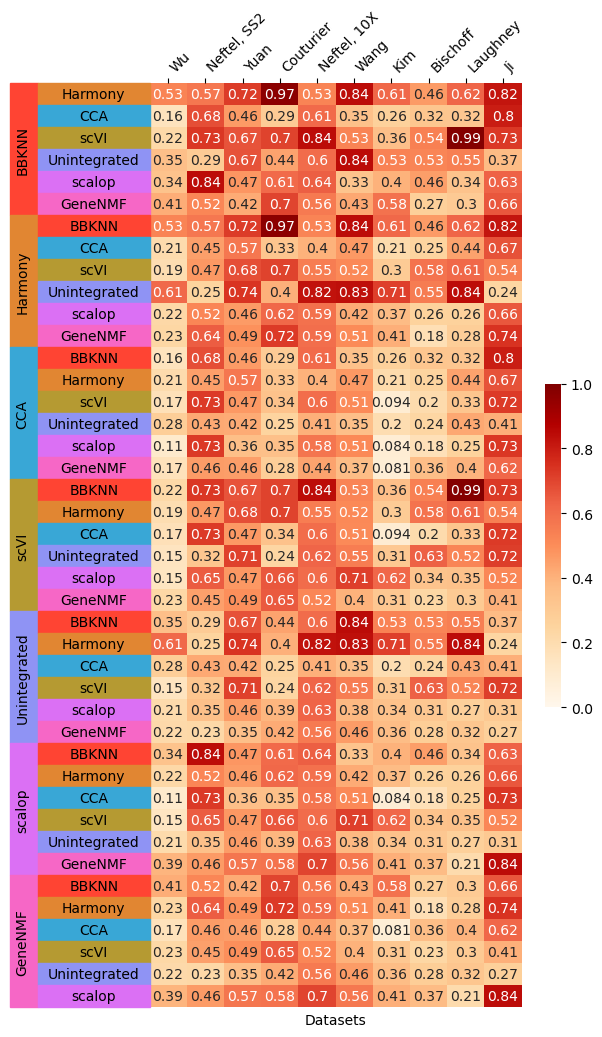

In [10]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 12))
sns.heatmap(results.astype(float).T, vmax=1., vmin=0., cmap="OrRd", ax=ax, cbar=True, annot=True, cbar_kws={"shrink": 0.35})
n_ticks = results.shape[1]
_offset= -0.375
for i, (method_1, method_2) in enumerate(results.columns):
    if not i % 6:
        rectangle = Rectangle((_offset, 1 - (i+6)/n_ticks), 0.075, 6/n_ticks, color=method_colormap[method_1], transform=ax.transAxes, clip_on=False)
        ax.add_patch(rectangle)
        ax.text(_offset+0.015, 1 - (i+6)/n_ticks + 6/(2*n_ticks), method_1, ha="left", va="center", transform=ax.transAxes, rotation=90)

    ax.text(-0.15, 1 - (i + 1)/(n_ticks) + 1/(2*(n_ticks)), method_2, ha="center", va="center", transform=ax.transAxes)
    rectangle = Rectangle((-0.3, 1 - (i+1)/n_ticks), 0.3, 1/n_ticks, color=method_colormap[method_2], transform=ax.transAxes, clip_on=False)
    ax.add_patch(rectangle)
#ax.hlines(y=[1 - i/(n_ticks) for i in range(1, (n_ticks))], xmin=[-0.1 - 0.2 * ((i % 3)==0) for i in range(1, (n_ticks))], xmax=0.0, colors="black", transform=ax.transAxes, clip_on=False)

ax.yaxis.set_tick_params(labelleft=True)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_ylabel("")

ax.xaxis.tick_top()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='left')
ax.set_xlabel("Datasets")
fig.savefig("fig_4/overview.svg")

In [19]:
mean = results.mean(0).groupby(level=0).mean().to_frame().T
mean = mean.sort_index(axis=1, key=lambda x: x.map(method_order.index))


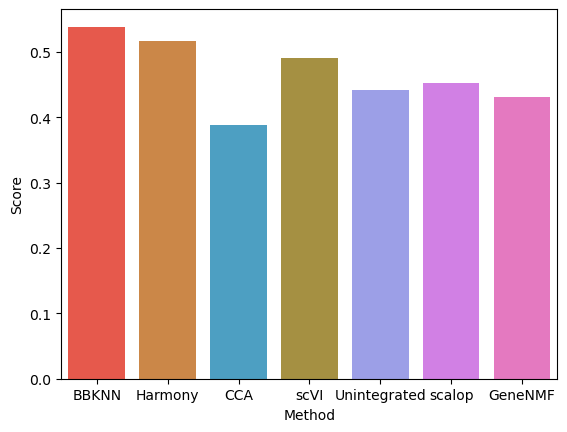

In [24]:
fig, ax = plt.subplots()
sns.barplot(mean, palette=method_colormap, ax=ax)
ax.set_ylabel("Score")
ax.set_xlabel("Method")

fig.savefig("fig_4/barplot.svg")

In [22]:
results.mean()

BBKNN                                                       \
              Harmony       CCA      scVI Unintegrated    scalop   GeneNMF   
Wu           0.530216  0.157686  0.219066     0.354877  0.338326  0.413737   
Neftel, SS2  0.566989  0.677915  0.730974     0.294880  0.842601  0.519775   
Yuan         0.721360  0.461534  0.666112     0.670957  0.473580  0.421867   
Couturier    0.965500  0.294308  0.703400     0.439932  0.607537  0.702118   
Neftel, 10X  0.529395  0.608072  0.842481     0.603296  0.638187  0.559998   
Wang         0.843565  0.347592  0.530576     0.843833  0.331954  0.426519   
Kim          0.614635  0.264283  0.355348     0.531418  0.398558  0.583285   
Bischoff     0.462102  0.322965  0.541817     0.525175  0.455408  0.269893   
Laughney     0.623651  0.319638  0.987623     0.546086  0.335968  0.298984   
Ji           0.817420  0.798867  0.728527     0.370177  0.630290  0.657246   

              Harmony                                   ...    scalop  \
                BBKNN       CCA      scVI Unintegrated  ...       CCA   
Wu           0.530216  0.206055  0.193166     0.609974  ...  0.110058   
Neftel, SS2  0.566989  0.449988  0.471513     0.252009  ...  0.728687   
Yuan         0.721360  0.569902  0.679113     0.739165  ...  0.355561   
Couturier    0.965500  0.326124  0.703422     0.403914  ...  0.348148   
Neftel, 10X  0.529395  0.400405  0.548332     0.824629  ...  0.575645   
Wang         0.843565  0.467558  0.515248     0.833394  ...  0.511767   
Kim          0.614635  0.207421  0.296597     0.714683  ...  0.084376   
Bischoff     0.462102  0.248694  0.580763     0.552299  ...  0.175235   
Laughney     0.623651  0.442726  0.613684     0.842378  ...  0.254930   
Ji           0.817420  0.668073  0.544349     0.238916  ...  0.731191   

                                               GeneNMF                      \
                 scVI Unintegrated   GeneNMF     BBKNN   Harmony       CCA   
Wu           0.145875     0.207752  0.393719  0.413737  0.234143  0.167881   
Neftel, SS2  0.646472     0.349587  0.463231  0.519775  0.640764  0.458311   
Yuan         0.470774     0.458098  0.573868  0.421867  0.490517  0.455188   
Couturier    0.657787     0.390350  0.581276  0.702118  0.723877  0.280976   
Neftel, 10X  0.604472     0.628463  0.699845  0.559998  0.594075  0.438006   
Wang         0.712734     0.382089  0.564055  0.426519  0.507210  0.365773   
Kim          0.621070     0.342223  0.409491  0.583285  0.406949  0.080551   
Bischoff     0.336442     0.313459  0.370481  0.269893  0.181386  0.362614   
Laughney     0.346669     0.273060  0.205872  0.298984  0.279478  0.396901   
Ji           0.518706     0.307844  0.843324  0.657246  0.743414  0.620609   

                                              
                 scVI Unintegrated    scalop  
Wu           0.226675     0.218091  0.393719  
Neftel, SS2  0.447080     0.225717  0.463231  
Yuan         0.494671     0.353130  0.573868  
Couturier    0.649057     0.418875  0.581276  
Neftel, 10X  0.522830     0.559183  0.699845  
Wang         0.402026     0.457140  0.564055  
Kim          0.314224     0.363941  0.409491  
Bischoff     0.233733     0.281879  0.370481  
Laughney     0.302040     0.321021  0.205872  
Ji           0.405498     0.273305  0.843324  

[10 rows x 42 columns]

,BBKNN,Harmony,CCA,scVI,Unintegrated,scalop,GeneNMF
0,0.538668,0.516558,0.388492,0.490874,0.441646,0.45199,0.430955


In [11]:
import pathlib
import scanpy as sc

for path in pathlib.Path("../results/").iterdir():
    if "_" in str(path):
        continue
    data_path = path.joinpath("data").joinpath("preprocessed")
    for file_path in data_path.iterdir():
        if file_path.name.endswith("rds"):
            continue
        adata = sc.read(file_path, backed="r")
        print(file_path.stem, adata.n_obs, adata.obs["sample"].nunique())

vazquez_ovarian 173189 125
bischoff_lung 10206 10
kim_lung 10409 12
laughney_lung 2648 9
couturier_brain 17116 11
yuan_brain 10627 6
neftel_smartseq2_brain 6696 26
wang_brain 7546 7
neftel_10x_brain 7500 8
wu_breast 21546 19
ji_skin 10529 8


INFO:metrics.corrs:Subsetting to non-cycling cells.
  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:06<00:40,  6.77s/it]

 29%|██▊       | 2/7 [00:13<00:33,  6.61s/it]

 43%|████▎     | 3/7 [00:19<00:26,  6.62s/it]

 57%|█████▋    | 4/7 [00:26<00:20,  6.67s/it]

 71%|███████▏  | 5/7 [00:33<00:13,  6.71s/it]

 86%|████████▌ | 6/7 [00:40<00:06,  6.72s/it]

100%|██████████| 7/7 [00:46<00:00,  6.70s/it]
INFO:metrics.corrs:Subsetting to non-cycling cells.
  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:30<03:00, 30.16s/it]

 29%|██▊       | 2/7 [00:59<02:29, 29.84s/it]

 43%|████▎     | 3/7 [01:29<01:58, 29.73s/it]

 57%|█████▋    | 4/7 [02:00<01:30, 30.12s/it]

 71%|███████▏  | 5/7 [02:29<01:00, 30.02s/it]

 86%|████████▌ | 6/7 [03:00<00:30, 30.19s/it]

100%|██████████| 7/7 [03:29<00:00, 29.88s/it]


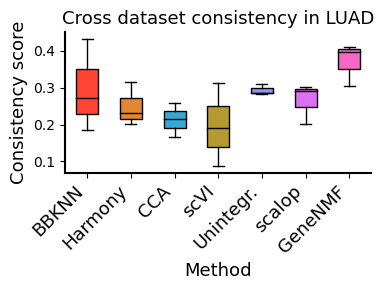

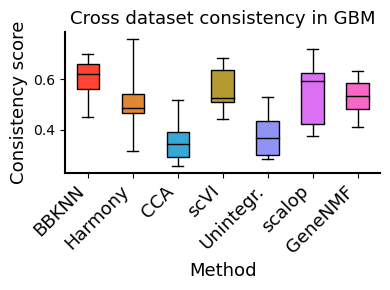

In [94]:
from itertools import combinations
from tqdm import tqdm


for scenario, sig in zip(["luad", "gbm"], ["kim_3", "neftel_4"]):
    cfg = yaml.safe_load(open(f"../configs/config_{scenario}.yml", "r"))

    root = cfg["root"]
    cfg_sig = cfg["signatures"][sig]
    scoring_scenario = cfg_sig["scoring_scenario"]
    n_cluster = cfg_sig["n_cluster"] + 2

    results = pd.DataFrame(index=list(config["methods"]), columns=pd.MultiIndex.from_tuples(combinations(cfg["scenarios"], r=2)))
    adata = get_adata(f"../{root}/data/preprocessed/{scoring_scenario}.h5ad")
    for method in tqdm(cfg["methods"]):
        for scenario_1, scenario_2 in results.columns:
            meta_sigs_1 = pd.read_csv(f"../{root}/metasigs/{method}/{scenario_1}_all_0/{n_cluster}/metasigs.csv")
            meta_sigs_1.columns = meta_sigs_1.columns + "_" + scenario_1
            meta_sigs_2 = pd.read_csv(f"../{root}/metasigs/{method}/{scenario_2}_all_0/{n_cluster}/metasigs.csv")
            meta_sigs_2.columns = meta_sigs_2.columns + "_" + scenario_2
            sigs_1, sigs_2, scores = get_scores(adata, meta_sigs_1, meta_sigs_2)
            corr = corr_signatures(scores, sigs_1, sigs_2)
            corr.pop("signature_type")
            result = 0.5 *(get_score(corr, sigs_1, sigs_2) + get_score(corr, sigs_2, sigs_1))
            results.loc[method,(scenario_1, scenario_2)] = result

    results = results.T
    results.columns = results.columns.map(methods_map)
    results = results.sort_index(axis=1, key=lambda x: x.map(method_order.index))

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_ylabel("Consistency score", fontdict={"fontsize": 13})
    ax.set_xlabel("Method", fontdict={"fontsize": 13})
    ax.set_title(f"Cross dataset consistency in {scenario.upper()}", fontdict={"fontsize": 13})
    bplot = ax.boxplot(results, whis=np.inf, patch_artist=True, labels=results.columns, medianprops=dict(color="black"))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontdict={"fontsize": 13})
    for patch, method in zip(bplot['boxes'], results.columns):
        patch.set_facecolor(method_colormap[method])
    # If you have a specific axis object 'ax'
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    fig.tight_layout()
    fig.savefig(f"fig_4/boxplot_{scenario}.svg")



In [ ]:
with torch.backends.cuda.sdp_kernel(
    enable_flash=True, enable_math=False
):
    start = time.time()
    for i in range(num_trials):
        out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_rate)
    end = time.time()
    print('Flash attention took {} seconds'.format(end - start))


start = time.time()
for i in range(num_trials):
    attn = q @ k.transpose(-2, -1)
    attn = attn.softmax(dim=-1)
    attn = F.dropout(attn, p=dropout_rate, training=True)
    x = (attn @ v).transpose(1, 2)  # .reshape(bz, seq_len, n_heads*dims)
end = time.time()

In [ ]:
from itertools import combinations_with_replacement
from tqdm import tqdm


results = None
for n_scenario, scenario in tqdm(enumerate(scenarios), total=len(scenarios)):
    cfg = scenarios[scenario]
    root = cfg["root"]
    signature = cfg["signatures"][0]
    cfg_sig = signatures[signature]
    scoring_scenario = cfg_sig["scoring_scenario"]
    n_cluster = cfg_sig["n_cluster"]
    adata = get_adata(f"../{root}/data/preprocessed/{scenario}.h5ad")
    methods = [path.stem for path in pathlib.Path(f"../{root}/metasigs/").iterdir()]
    idx = [(method_1, method_2) for method_1, method_2 in product(methods, methods) if method_1 != method_2]

    if results is None:
        results = pd.DataFrame(index=list(scenarios.keys()), columns=pd.MultiIndex.from_tuples(idx))
        

    for i in range(len(methods)):
        method_1 = methods[i]
        for j in range(i+1, len(methods)):
            method_2 = methods[j]
            meta_sigs_1 = pd.read_csv(f"../{root}/metasigs/{method_1}/{scenario}_all_0/{n_cluster}/metasigs.csv")
            meta_sigs_1.columns = meta_sigs_1.columns + "_" + method_1
            meta_sigs_2 = pd.read_csv(f"../{root}/metasigs/{method_2}/{scenario}_all_0/{n_cluster}/metasigs.csv")
            meta_sigs_2.columns = meta_sigs_2.columns + "_" + method_2
            sigs_1, sigs_2, scores = get_scores(adata, meta_sigs_1, meta_sigs_2)
            corr = corr_signatures(scores, sigs_1, sigs_2)
            corr.pop("signature_type")
            result = 0.5 *(get_score(corr, sigs_1, sigs_2) + get_score(corr, sigs_2, sigs_1))
            results.loc[scenario,(method_1, method_2)] = result